In [2]:
import os
import fnmatch
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import torch
import random
from math import floor
import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import np_utils

In [3]:
os.chdir('/content/drive/MyDrive/07project')

In [4]:
def read_pdb_train(filename):

	with open(filename, 'r') as file:
		strline_L = file.readlines()
		# print(strline_L)

	X_list = list()
	Y_list = list()
	Z_list = list()
	atomtype_list = list()
	for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
		stripped_line = strline.strip()

		line_length = len(stripped_line)
		# print("Line length:{}".format(line_length))
		if line_length < 78:
			print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
		
		X_list.append(float(stripped_line[30:38].strip()))
		Y_list.append(float(stripped_line[38:46].strip()))
		Z_list.append(float(stripped_line[46:54].strip()))

		atomtype = stripped_line[76:78].strip()
		if atomtype == 'C':
			atomtype_list.append('h') # 'h' means hydrophobic
		else:
			atomtype_list.append('p') # 'p' means polar

	return X_list, Y_list, Z_list, atomtype_list

In [5]:
def read_pdb_test(filename):
	
	with open(filename, 'r') as file:
		strline_L = file.readlines()
		# print(strline_L)

	X_list = list()
	Y_list = list()
	Z_list = list()
	atomtype_list = list()
	for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
		stripped_line = strline.strip()
		# print(stripped_line)

		splitted_line = stripped_line.split('\t')
		
		X_list.append(float(splitted_line[0]))
		Y_list.append(float(splitted_line[1]))
		Z_list.append(float(splitted_line[2]))
		atomtype_list.append(str(splitted_line[3]))

	return X_list, Y_list, Z_list, atomtype_list


# plot

In [49]:
#plot positive & negative pro-lig structure
def plot_PosNeg(pro1,pro2,lig1,lig2):
  fig = plt.figure(figsize=(30, 10))

  ax = fig.add_subplot(131, projection='3d')
  ax.scatter(pro1[0], pro1[1], pro1[2], c='r')
  ax.scatter(lig1[0], lig1[1], lig1[2], c='b')
  ax.set_title("Positive pro-lig")
  ax.legend(["pro0", "lig0"])

  ax = fig.add_subplot(132, projection='3d')
  ax.scatter(pro1[0], pro1[1], pro1[2], c='r')
  ax.scatter(lig2[0], lig2[1], lig2[2], c='b')
  ax.set_title("Negative pro-lig")
  ax.legend(["pro0", "lig1"])

  ax = fig.add_subplot(133, projection='3d')
  ax.scatter(pro2[0], pro2[1], pro2[2], c='r')
  ax.scatter(lig2[0], lig2[1], lig2[2], c='b')
  ax.set_title("Positive pro-lig")
  ax.legend(["pro1", "lig1"])

  plt.show()

# read data

In [57]:
pro=[]
atom_num=[]
lig=[]
lig_num=[]
path_list = os.listdir('/content/drive/MyDrive/07project/training_data')
path_list.sort(key=lambda x:str(x[:-9]))
for i in range(0,len(fnmatch.filter(os.listdir('/content/drive/MyDrive/07project/training_data'), '*lig_cg.pdb'))):
  lig.append(read_pdb_train('training_data/'+path_list[2*i]))
  pro.append(read_pdb_train('training_data/'+path_list[2*i+1]))
  atom_num.append(len(pro[i][0]))
  lig_num.append(len(lig[i][0]))

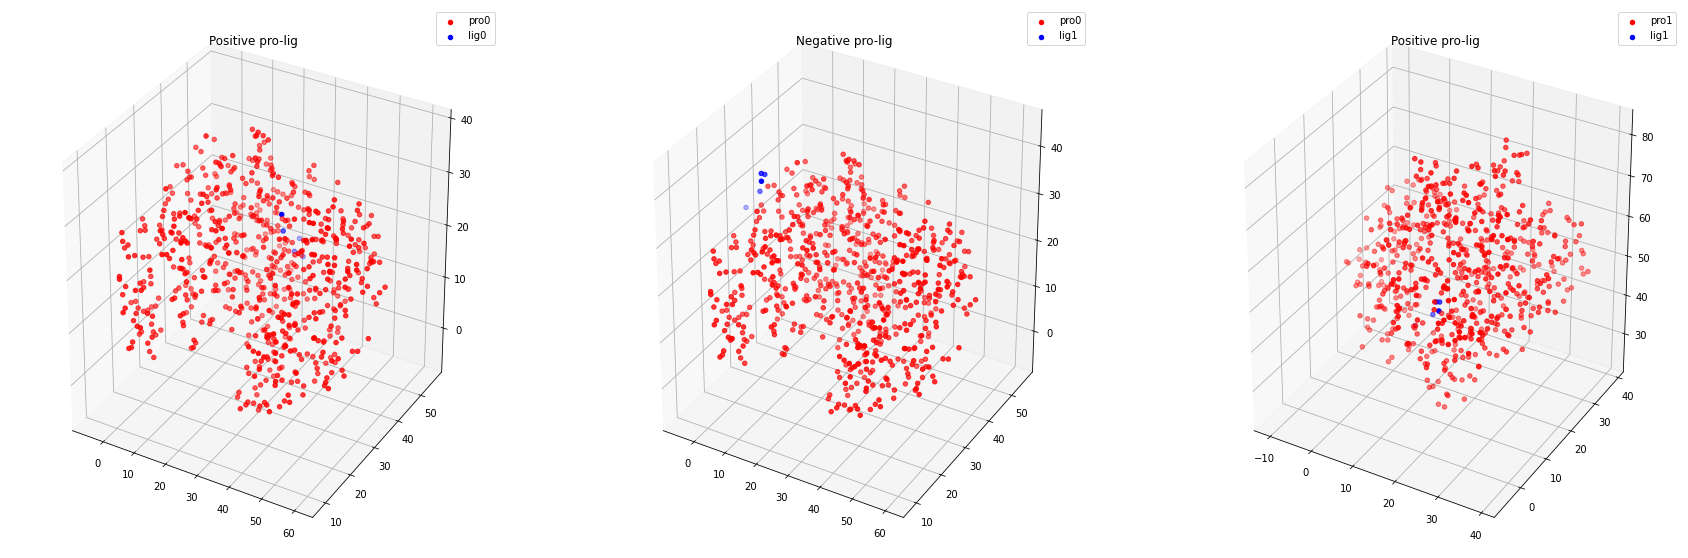

In [58]:
plot_PosNeg(pro[0],pro[1],lig[0],lig[1])

In [59]:
#use the mean location of lig
new_lig=[]
new_pro=[]
for i in range(len(lig)):
  center = np.mean(lig[i][:3],axis=1)
  ligi=np.round(((lig[i][0]-center[0]).tolist(),(lig[i][1]-center[1]).tolist(),(lig[i][2]-center[2]).tolist()),3).tolist()
  ligi.append(lig[i][3])
  new_lig.append(ligi)

  proi=np.round(((pro[i][0]-center[0]).tolist(),(pro[i][1]-center[1]).tolist(),(pro[i][2]-center[2]).tolist()),3).tolist()
  proi.append(pro[i][3])
  new_pro.append(proi)


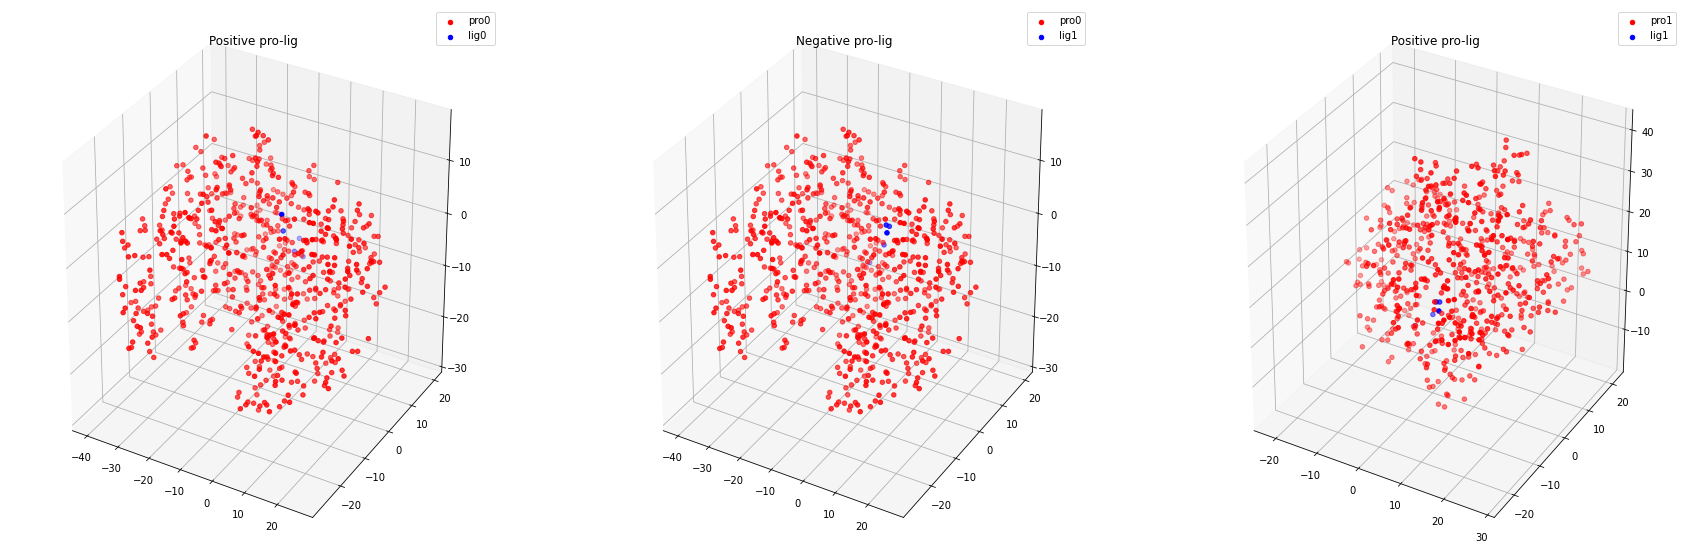

In [60]:
plot_PosNeg(new_pro[0],new_pro[1],new_lig[0],new_lig[1])

# find width

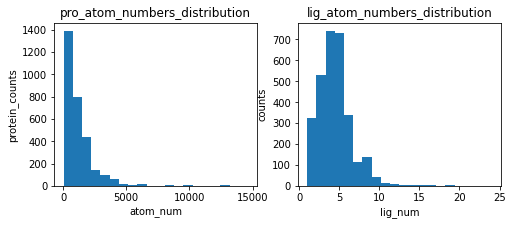

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
ax.hist(atom_num,bins= 20)
ax.set_title("pro_atom_numbers_distribution")
ax.set_xlabel("atom_num")
ax.set_ylabel("protein_counts")
ax = fig.add_subplot(122)
ax.hist(lig_num,bins= 20)
ax.set_title("lig_atom_numbers_distribution")
ax.set_xlabel("lig_num")
ax.set_ylabel("counts")
plt.show()

In [ ]:
#each atom in the protein 's distance to the center of lig
def cal_dis(new_pro_or_lig):
  max_dis_x = []
  max_dis_y = []
  max_dis_z = []
  for i in range(len(new_pro_or_lig)):
    max_dis_x.append(np.max(np.abs(new_pro_or_lig[i][0])))
    max_dis_y.append(np.max(np.abs(new_pro_or_lig[i][1])))
    max_dis_z.append(np.max(np.abs(new_pro_or_lig[i][2])))
  dis = pd.DataFrame([max_dis_x,max_dis_y,max_dis_z],index=['max_dis_x','max_dis_y','max_dis_z']).T
  return dis

In [ ]:
pro_dis = cal_dis(new_pro)
pro_dis.describe()

max_dis_x    max_dis_y    max_dis_z
count  3000.000000  3000.000000  3000.000000
mean     39.992332    40.369756    42.849595
std      18.789359    19.764227    21.467782
min       8.642000    10.116000    10.380000
25%      27.066750    27.489750    28.384250
50%      34.487500    34.577000    36.072000
75%      47.493000    47.796250    50.304500
max     282.240000   261.039000   271.938000

In [ ]:
lig_dis = cal_dis(new_lig)
lig_dis.describe()

max_dis_x    max_dis_y    max_dis_z
count  3000.000000  3000.000000  3000.000000
mean      3.379655     3.198706     3.317238
std       2.402560     2.441498     2.612978
min       0.000000     0.000000     0.000000
25%       1.821000     1.666250     1.790500
50%       3.045500     2.768500     2.905000
75%       4.387000     4.173000     4.297750
max      25.847000    39.816000    48.382000

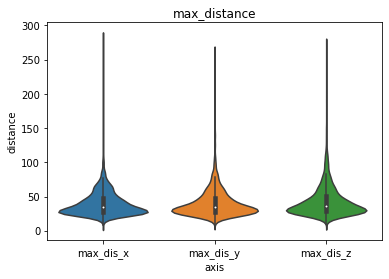

In [ ]:
sns.violinplot(data = dis)
plt.title("max_distance")
plt.xlabel("axis")
plt.ylabel("distance")
plt.show()

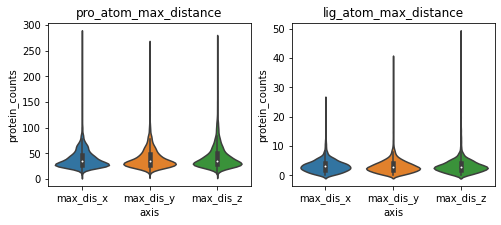

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
ax = sns.violinplot(data = pro_dis)
ax.set_title("pro_atom_max_distance")
ax.set_xlabel("axis")
ax.set_ylabel("protein_counts")
ax = fig.add_subplot(122)
ax = sns.violinplot(data = lig_dis)
ax.set_title("lig_atom_max_distance")
ax.set_xlabel("axis")
ax.set_ylabel("protein_counts")
plt.show()

# choose atoms

In [61]:
def choose_pro_lig(new_lig_pro,width):
  chosen_lig_pro = []
  for i in range(len(new_lig_pro)):
    chosen_lig_pro_i=[]
    for j in range(len(new_lig_pro[i][0])):
      if np.abs(new_lig_pro[i][0][j])<width and np.abs(new_lig_pro[i][1][j])<width and np.abs(new_lig_pro[i][2][j])<width:
        chosen_lig_pro_i.append([new_lig_pro[i][0][j],new_lig_pro[i][1][j],new_lig_pro[i][2][j],new_lig_pro[i][3][j]])
    chosen_lig_pro.append(chosen_lig_pro_i)
  return chosen_lig_pro


In [64]:
def chosen_xy_transform(chosen_pro_lig):
  output=[]
  for i in range(len(chosen_pro_lig)):
    outputi=[]
    for j in range(4):
      outputi.append([a[j] for a in chosen_pro_lig[i]])
    output.append(outputi)
  return output

In [76]:
width=10
chosen_lig = choose_pro_lig(new_lig,width)
chosen_pro = choose_pro_lig(new_pro,width)

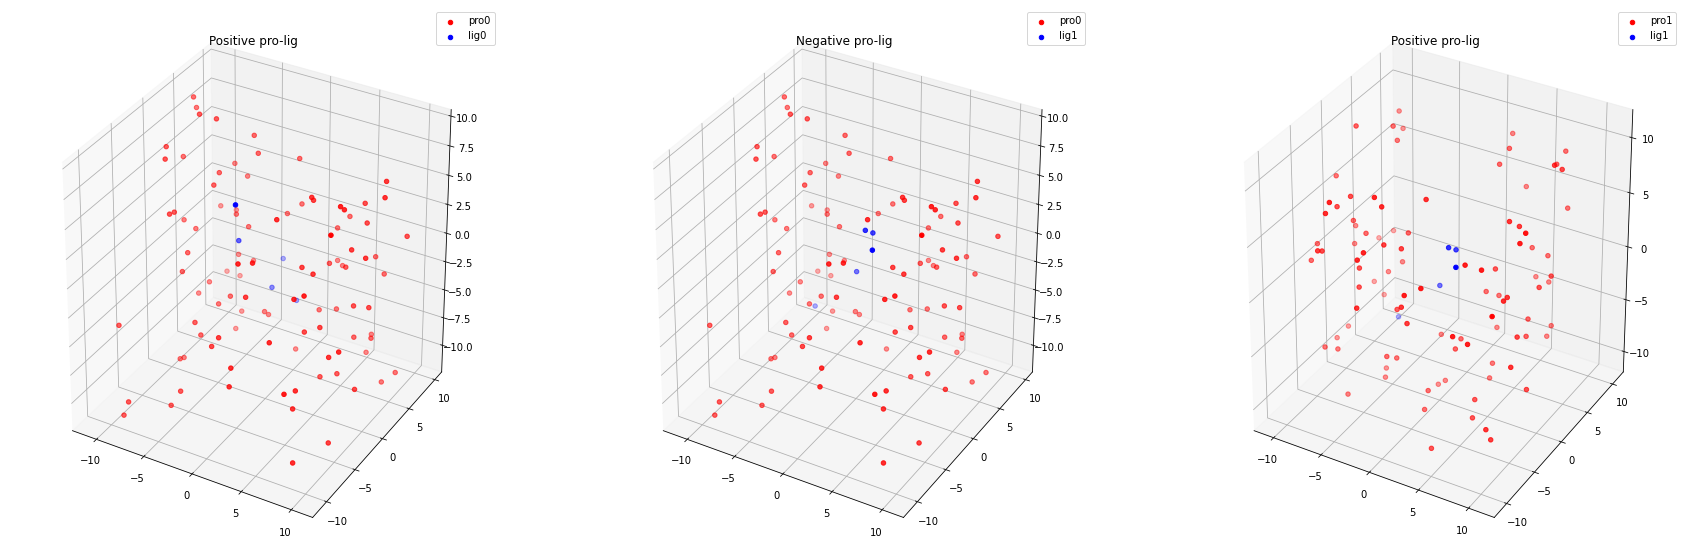

In [66]:
plot_PosNeg(chosen_pro[0],chosen_pro[1],chosen_lig[0],chosen_lig[1])

In [26]:
#for a protein
def convert_4D(pro_lig_i,pro_or_lig):#for a protein
    xyz_hp_4D = np.zeros((2*width, 2*width, 2*width, 1))
    for atom in pro_lig_i:
      (x, y, z, hp) = atom
      if hp =='h':
        if pro_or_lig==1: #pro-h=1
          xyz_hp_4D[int(x),int(y),int(z), 0] = 1
        if pro_or_lig==0: #lig-h=-1
          xyz_hp_4D[int(x),int(y),int(z), 0] = -1
      elif hp =='p':
        if pro_or_lig==1: #pro-p=2
          xyz_hp_4D[int(x),int(y),int(z), 0] = 2
        if pro_or_lig==0: #lig-h=-2
          xyz_hp_4D[int(x),int(y),int(z), 0] = -2
    return np.array(xyz_hp_4D)

In [74]:
#def connect_PL_pair(pro_index,lig_index,pro_list,lig_list,label_list,lig_data,pro_data,width):
def connect_PL_pair(pro_index,lig_index,pro_lig_list,label_list,lig_data,pro_data,width):
  current_lig_pro = []
  if pro_index==lig_index:
    label_list.append(1)
  if pro_index!=lig_index:
    label_list.append(0)
  current_lig_pro = np.concatenate([convert_4D(lig_data[lig_index],0),convert_4D(pro_data[pro_index],1)],axis=-1)
  #current_lig_pro.append([convert_4D(lig_data[lig_index],0),convert_4D(pro_data[pro_index],1)])
  pro_lig_list.append(current_lig_pro)


In [77]:
validat_index = [x for x in np.random.choice(len(chosen_lig), 600, replace=False)]
train_index = list(set(list(range(3000))).difference(set(validat_index)))

In [78]:
#train_pro = []
#train_lig = []
train_label = []
train_pro_lig = []
for index in train_index:
  for i in range(10):
    negative_index = random.choice(list(set(train_index).difference(set([index]))))
    #negative PL pairs
    #connect_PL_pair(index,negative_index,train_pro,train_lig,train_label,chosen_lig,chosen_pro,width)
    connect_PL_pair(index,negative_index,train_pro_lig,train_label,chosen_lig,chosen_pro,width)
  #positive PL pairs
  for i in range(10):
    connect_PL_pair(index,index,train_pro_lig,train_label,chosen_lig,chosen_pro,width)
  #connect_PL_pair(index,index,train_pro,train_lig,train_label,chosen_lig,chosen_pro,width)

In [79]:
validat_label = []
validat_pro_lig = []
for index in validat_index:
  for i in range(10):
    negative_index = random.choice(list(set(validat_index).difference(set([index]))))
    connect_PL_pair(index,negative_index,validat_pro_lig,validat_label,chosen_lig,chosen_pro,width)
  #positive PL pairs
  connect_PL_pair(index,index,validat_pro_lig,validat_label,chosen_lig,chosen_pro,width)

In [42]:
from collections import Counter
Counter(train_label)#.count()

Counter({0: 24000, 1: 24000})

In [ ]:
np.array(train_pro_lig).shape
np.array(validat_pro_lig).shape

In [80]:
X_train, X_test, y_train, y_test = train_test_split(train_pro_lig, train_label, test_size=0.2, random_state=23, stratify=train_label)

In [16]:
len(X_train)

38400

In [14]:
from keras import backend as K
K.image_data_format() == 'channels_last'
input_shape = (22,22,22,2)
num_classes=2
model = keras.Sequential(
    [
     keras.Input(shape = input_shape), 
     layers.Conv3D(32, kernel_size = (3,3,3), activation = 'relu'),
     layers.MaxPooling3D(pool_size = (2,2,2)), 
     layers.BatchNormalization(),

     layers.Conv3D(64, kernel_size = (3,3,3), activation = 'relu'),
     layers.MaxPooling3D(pool_size = (2,2,2)), 
     layers.BatchNormalization(),

     layers.Conv3D(128, kernel_size = (3,3,3), activation = 'relu'),
     layers.MaxPooling3D(pool_size = (2,2,2)), 
     layers.BatchNormalization(),
     
     layers.Flatten(),
     layers.Dropout(0.5), # this removes random neurons(50%) to reduce overfitting

     layers.Dense(num_classes, activation = 'softmax')
    ]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 18, 18, 32)    1760      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 9, 9, 32)      0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 9, 9, 9, 32)      128       
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 7, 7, 64)       55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 3, 3, 64)      0         
 3D)                                                             
                                                      

In [17]:
from keras.utils import np_utils
trainY = np_utils.to_categorical(y_train, 2)
testY = np_utils.to_categorical(y_test, 2)

In [ ]:
trainY


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:
validatY = np_utils.to_categorical(validat_label, 2)

In [33]:
np.array(X_train).shape

(28800, 24, 24, 24, 2)

In [19]:
# train our model
batch_size = 256
epochs =40
opt = tf.keras.optimizers.Adam(learning_rate=1e-03)
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.8)
model.compile(loss = 'categorical_crossentropy',
              #optimizer = sgd,
              optimizer =opt,
              metrics = ['accuracy'])

In [ ]:
X_train = np.array(X_train)
history = model.fit(X_train, trainY, batch_size = batch_size, epochs = epochs, validation_split = 0.2)#validation_data=(X_test,testY))

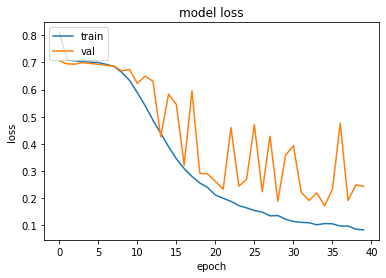

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

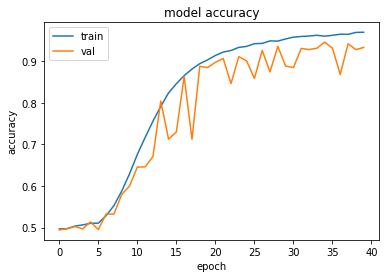

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test

In [81]:
model=tf.keras.models.load_model('model3_96.h5')
X_test = np.array(validat_pro_lig)
test_predict = model.predict(X_test)

In [44]:
pd.DataFrame(test_predict).sort_values(by=1,ascending=False).head(10)

0    1
6599  4.345437e-10  1.0
6324  1.435393e-08  1.0
5587  1.711719e-08  1.0
5433  1.543408e-10  1.0
5257  5.705916e-10  1.0
5190  4.066281e-08  1.0
5158  2.937883e-09  1.0
4586  2.340165e-08  1.0
296   1.310869e-08  1.0
4382  2.375597e-09  1.0

In [82]:
#accuracy_score(testY, test_predict)
for i in range(len(test_predict)):
    test_predict[i][np.argmax(test_predict[i])]=1.0
    test_predict[i][np.argmin(test_predict[i])]=0.0

In [83]:
accuracy_score(test_predict, validatY)

0.8953030303030303

Text(0.5, 117.59999999999997, 'Predicted label')

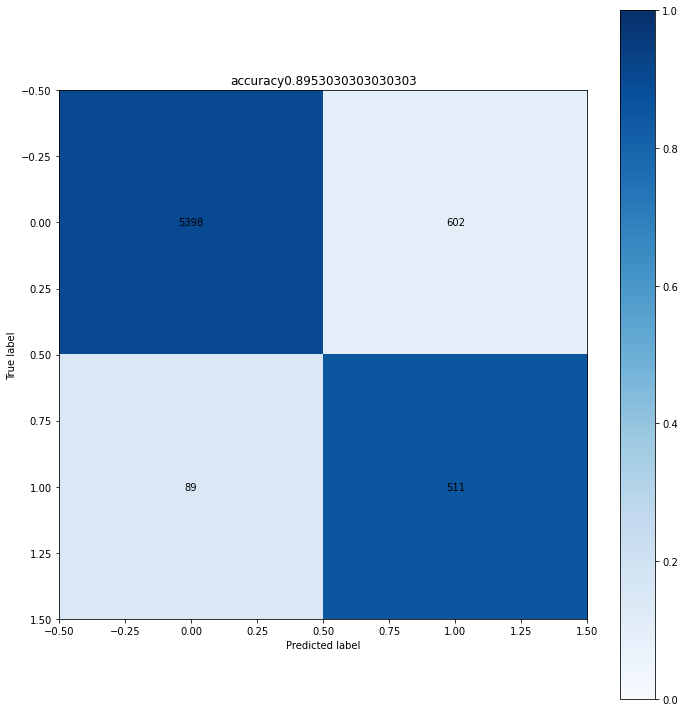

In [84]:
from sklearn.metrics import confusion_matrix
cmap=plt.cm.Blues
y = np.argmax(validatY, axis=-1)   
pred= np.argmax(test_predict, axis=-1)  
labels = np.unique(y)
cm = confusion_matrix(y,  pred);
ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = accuracy_score(validatY, test_predict)

fig = plt.figure(figsize=(10, 10))
plt.imshow(ncm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
plt.colorbar()
for i in range(0,len(labels)):
    for j in range(0,len(labels)):
        plt.text(j,i,cm[i,j],va='center',ha='center')
#tick_marks = np.arange(len(labels))
#plt.xticks(tick_marks, labels, rotation=45)
#plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.title('accuracy'+str(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [25]:
accuracy_score(validatY, test_predict)

0.5713636363636364

In [18]:
model.save('model7_96_10_10_w11.h5') 